# Using Sequence Packing to Improve PreTraining in ESM-2 with BioNeMo Recipes
This Starter Kit demonstrates pretraining the [ESM-2 model](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v2) using BioNeMo Recipes.
BioNeMo Recipes showcases an easy path to accelerate, scale and deploy transformer based biological foundation models using NVIDIA [TransformerEngine](https://github.com/NVIDIA/TransformerEngine).To learn more about BioNeMo Recipes, checkout the the Github repo: https://github.com/NVIDIA/bionemo-framework/tree/main/bionemo-recipes

ESM2 is pre-trained, bi-directional encoder (BERT-style model) over amino acid sequences. ESM-2 models provide embeddings for amino acids that have led to state-of-the-art performance on downstream tasks such as structure and function prediction. ESM2

The ESM2 recipe example also includes sequence packing with THD (Total, Height, Depth) format to achieve maximum computational efficiency when training on variable-length protein sequences. This example will showcase and pretrain the ESM2 model with and without sequence packing to showcase it's benefits. 


#### Requirements:
* must be run on the Ampere version or above hardware
* should be run on the NGC `pytorch:25.06-py3`image with TransformerEngine

#### Dataset:
This example will use a subset of the `esm2_uniref_pretraining_data` available on [HuggingFace](https://huggingface.co/datasets/nvidia/esm2_uniref_pretraining_data)

## Setting up BioNeMo Recipes

To start using BioNeMo Recipes, you will need to clone BioNeMo Framework from github and install the `requirements.txt` for your desired recipe. 

This example uses the [`esm2_native_te` recipe from BioNeMo Recipes](https://github.com/NVIDIA/bionemo-framework/tree/main/bionemo-recipes/recipes/esm2_native_te).


In [ ]:
%%bash

git clone https://github.com/NVIDIA/bionemo-framework.git
cd bionemo-framework/bionemo-recipes/recipes
pip install -r esm2_native_te/requirements.txt

Cloning into 'bionemo-framework'...


## ESM2 Training with Megatron FDSP

The ESM2 training recipe has support for the following parallelism strategies:
* [Distributed Data Parallelism (DDP)](https://docs.pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html) - The full model is replicated onto each gpu and data is batched and split amongst the GPUs
* [Fully Sharded Data Paralleism (FSDP2)](https://docs.pytorch.org/docs/stable/distributed.fsdp.fully_shard.html) - The model parameters, gradients and optimizer states are all sharded. This allows for models that do not fit on a single GPU to be trained.
* [Megatron-FSDP (mFSDP)](https://github.com/NVIDIA/Megatron-LM/tree/main/megatron/core/distributed/fsdp/src) - An NVIDIA implementation of FSDP that provides up to a 25% speed up and 23% memory savings compared to FSDP2

In this example, we will be showing training with mFSDP; however, DDP and FSDP2 can be used by replacing `train_mfsdp` with `train_ddp.py` and `train_fsdp2.py` respectively.

In [ ]:
%%bash
cd bionemo-framework/bionemo-recipes/recipes/esm2_native_te
torchrun train_mfsdp.py --config-name L0_sanity \
    dataset.micro_batch_size=48 \
    num_train_steps=200

## ESM2 Training with Sequence Packing
Sequence Packing is this recipe is implemented in THD (Total, Height, Depth) format to achieve maximum computational efficiency when training on variable-length protein sequences. 
Let's explore the value of using sequence packing for your data.

### The Problem with Traditional Padding

Traditional BERT-like models pad all sequences to the same length, leading to significant computational waste:

- **Memory waste**: Padding tokens consume GPU memory but provide no learning signal
- **FLOPS waste**: Every layer processes padding tokens through expensive operations (attention, feed-forward)
- **Scaling issues**: Waste increases with batch size and sequence length variance

For protein sequences with high length variability (50-1000+ amino acids), padding can waste **65-90% of computation**.

Let's take a look at the data in the `train.parquet`.

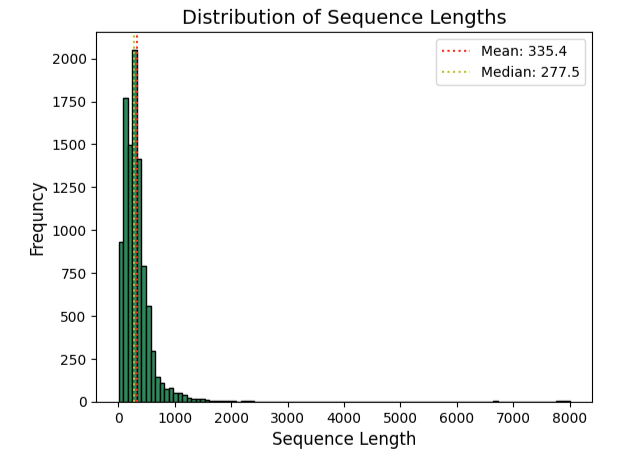 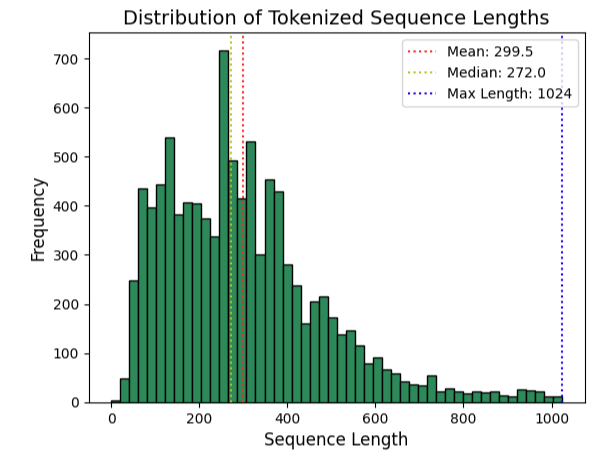

Looking at these graphs, if the training config uses a sequence length of 1024, the average tokens per sequence is 300 which means that over 70% of the data pads!


### THD Format with Sequence Packing

Instead of padding, we can:
1. **Concatenate sequences** without padding tokens
2. **Pack multiple sequences** into efficient batches
3. **Use Transformer Engine w/ Flash Attention** with sequence boundary metadata (`cu_seq_lens`)
4. **Achieve 100% computational efficiency** - every FLOP contributes to learning

Let's run the ESM-2 training with sequence packing to compare against the previous mean unpadded tokens per seconds. To turn on sequence packing, we set `dataset.use_sequence_packing=true` in the ESM-2 config.


In [ ]:
%%bash
cd bionemo-framework/bionemo-recipes/recipes/esm2_native_te
torchrun train_mfsdp.py --config-name L0_sanity \
    ++dataset.use_sequence_packing=true \
    dataset.micro_batch_size=48 \
    num_train_steps=200 \

## Comparison of Sequence Packed Performance vs non-Sequence Packed

A simple comparison to confirm that sequence packing has improved performance is by looking at the mean unpadded tokens per second (per GPU). Scrolling to the end of your training log you will see a value for the `Mean unpadded tokens per second (per GPU) (last 100 steps)`. In the training with sequence packing, you should see that more tokens are proceeded per second per GPU than without sequence packing. 